# 01_BigMartSalesPrediction

The goals of this assignment are: 

- To analyze a set of data collected at the shops of a retail company, and figure out what variables within this dataset are the most important in the sales prediciton process;
- To build a statistical model that can produce results competitive in comparison with other results on the hackathon's leaderboard.

More info on the competition, as well as the relevant datasets, are available on the hackathon's web page https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/ 

## 0. Preliminary stage

### 0.1 Activating the working directory:

In [1]:
cd D:\SciKitDatasets\misc\BigMart3

D:\SciKitDatasets\misc\BigMart3


### 0.2 Importing the necessary libraries:

In [2]:
import pandas as pd #Pandas
import matplotlib.pyplot as plt #Matplotlib

from sklearn.linear_model import LinearRegression #Logistic regression srcipt from sklearn package
from sklearn.ensemble import RandomForestRegressor #Random Forest srcipt from sklearn package
from sklearn.model_selection import train_test_split #Splitting the data into train and test datasets
from sklearn.feature_selection import RFECV #Recursive feature elimination and cross-validation script 
                                            #from sklearn package
from sklearn.metrics import mean_squared_error #Mean squared error script from sklearn package
from sklearn.tree import export_graphviz #Visualizing decicion trees

import numpy as np #NumPy

import seaborn as sns #Seaborn package for more advanced visualization
sns.set(style="white") #White background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline

In [3]:
#Ignoring unnecessary warnings
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Displaying images within the notebook:
from IPython.display import Image

from subprocess import call

#Script for displaying multiple tables in one row:
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

### 0.3 Uploading the dataset file Train.csv into a pandas dataframe, assigning the names df_full (raw data) and df_train (for data cleaning and model training) to it: 

In [5]:
df_full = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\Train.csv')

In [6]:
df_train = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\Train.csv')

### 0.4 Reviewing the dataset parameters, and noting that it consists of 8523 rows and 12 columns: 

In [7]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Columns: 12 entries, Item_Identifier to Item_Outlet_Sales
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


### 0.5 Having a look at some variables within the dataset: 

In [8]:
df_train.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### 0.6 Having a look at the overall description of the numercial variables of the dataset:

Here we discover that the Item_Weight column has almost 1,5 thousand missing values, which need to be imputed in order to be able to use the data for building a machine learning model. 

In [9]:
df_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### 0.6.1 Imputing the missing Item_Weigth values with the median value of the column:

In [10]:
df_train.median()

Item_Weight                    12.600000
Item_Visibility                 0.053931
Item_MRP                      143.012800
Outlet_Establishment_Year    1999.000000
Item_Outlet_Sales            1794.331000
dtype: float64

In [11]:
df_train["Item_Weight"].fillna(12.600000, inplace=True)

### 0.7 Having a look at the categorical variables of the dataset:

In [12]:
def describe_categorical(df):
    from IPython.display import display, HTML
    display(HTML(df[df.columns[df.dtypes == 'object']].describe().to_html()))

In [13]:
describe_categorical(df_train)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDG33,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


#### 0.7.1 Deleting the Item_Identifier variable:

This variable cannot have any reasonable significance during the model development proces, as it has more than 1,5 thousand unique values within a 8,5 thousand dataset.

In [14]:
df_train.drop(["Item_Identifier"], axis=1, inplace=True)

#### 0.7.2 Imputing missing values in the Outlet_Size column:

In [15]:
df_train["Outlet_Size"].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

Since the 'Medium' value is the most frequent, we might as well use it to fill the missing data. 

In [16]:
df_train["Outlet_Size"].fillna('Medium', inplace=True)

#### 0.7.3 Merging Item_Fat_Content values:

There are 'LF' and 'low fat' values in the Item_Fat_Content column, and they need to be substituted with a single value - 'Low Fat'. 

In [17]:
df_train["Item_Fat_Content"].replace('LF', 'Low Fat',inplace=True)
df_train["Item_Fat_Content"].replace('reg', 'Regular',inplace=True)
df_train["Item_Fat_Content"].replace('low fat', 'Low Fat',inplace=True)

#### 0.7.4 Converting categorical variables into numerical:

In order to be able to use the dataset for developing a predictive model, we need to make sure that the final dataset has only numerical variables in it.

In [18]:
df_train["Item_Fat_Content"].replace('Low Fat', 1,inplace=True)
df_train["Item_Fat_Content"].replace('Regular', 2,inplace=True)

df_train["Item_Type"].replace('Fruits and Vegetables', 1,inplace=True)
df_train["Item_Type"].replace('Snack Foods', 2,inplace=True)
df_train["Item_Type"].replace('Household', 3,inplace=True)
df_train["Item_Type"].replace('Frozen Foods', 4,inplace=True)
df_train["Item_Type"].replace('Dairy', 5,inplace=True)
df_train["Item_Type"].replace('Canned', 6,inplace=True)
df_train["Item_Type"].replace('Baking Goods', 7,inplace=True)
df_train["Item_Type"].replace('Health and Hygiene', 8,inplace=True)
df_train["Item_Type"].replace('Soft Drinks', 9,inplace=True)
df_train["Item_Type"].replace('Meat', 10,inplace=True)
df_train["Item_Type"].replace('Breads', 11,inplace=True)
df_train["Item_Type"].replace('Hard Drinks', 12,inplace=True)
df_train["Item_Type"].replace('Others', 13,inplace=True)
df_train["Item_Type"].replace('Starchy Foods', 14,inplace=True)
df_train["Item_Type"].replace('Breakfast', 15,inplace=True)
df_train["Item_Type"].replace('Seafood', 16,inplace=True)

df_train["Outlet_Identifier"].replace('OUT027', 1,inplace=True)
df_train["Outlet_Identifier"].replace('OUT013', 2,inplace=True)
df_train["Outlet_Identifier"].replace('OUT046', 3,inplace=True)
df_train["Outlet_Identifier"].replace('OUT049', 4,inplace=True)
df_train["Outlet_Identifier"].replace('OUT035', 5,inplace=True)
df_train["Outlet_Identifier"].replace('OUT045', 6,inplace=True)
df_train["Outlet_Identifier"].replace('OUT018', 7,inplace=True)
df_train["Outlet_Identifier"].replace('OUT017', 8,inplace=True)
df_train["Outlet_Identifier"].replace('OUT010', 9,inplace=True)
df_train["Outlet_Identifier"].replace('OUT019', 10,inplace=True)

df_train["Outlet_Size"].replace('Small', 1,inplace=True)
df_train["Outlet_Size"].replace('Medium', 2,inplace=True)
df_train["Outlet_Size"].replace('High', 3,inplace=True)

df_train["Outlet_Location_Type"].replace('Tier 3', 1,inplace=True)
df_train["Outlet_Location_Type"].replace('Tier 2', 2,inplace=True)
df_train["Outlet_Location_Type"].replace('Tier 1', 3,inplace=True)

df_train["Outlet_Type"].replace('Supermarket Type1', 1,inplace=True)
df_train["Outlet_Type"].replace('Grocery Store', 2,inplace=True)
df_train["Outlet_Type"].replace('Supermarket Type3', 3,inplace=True)
df_train["Outlet_Type"].replace('Supermarket Type2', 4,inplace=True)

Now the training dataset is completely ready for being used for model development.

In [19]:
df_train.describe()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523.00000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.81342,1.352693,0.066132,5.433885,140.992782,5.128711,1997.831867,1.829168,1.887129,1.673120,2181.288914
std,4.22724,0.477836,0.051598,3.754673,62.275067,2.717035,8.371760,0.600327,0.812757,1.045397,1706.499616
min,4.55500,1.000000,0.000000,1.000000,31.290000,1.000000,1985.000000,1.000000,1.000000,1.000000,33.290000
25%,9.31000,1.000000,0.026989,2.000000,93.826500,3.000000,1987.000000,1.000000,1.000000,1.000000,834.247400
50%,12.60000,1.000000,0.053931,5.000000,143.012800,5.000000,1999.000000,2.000000,2.000000,1.000000,1794.331000
75%,16.00000,2.000000,0.094585,8.000000,185.643700,7.000000,2004.000000,2.000000,3.000000,2.000000,3101.296400
max,21.35000,2.000000,0.328391,16.000000,266.888400,10.000000,2009.000000,3.000000,3.000000,4.000000,13086.964800


In [20]:
df_train.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\train1.csv', index=False)

### 0.8 Adjusting the test dataset respectively:

In order to be able to make predictions and submit the results for checking on the hackathon's page, the test dataset needs to have the same properties as the training one. 

In [21]:
df_test = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\Test.csv')

In [22]:
df_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Columns: 11 entries, Item_Identifier to Outlet_Type
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [23]:
df_test.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [24]:
df_test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


In [25]:
df_test.median()

Item_Weight                    12.500000
Item_Visibility                 0.054154
Item_MRP                      141.415400
Outlet_Establishment_Year    1999.000000
dtype: float64

In [26]:
df_test["Item_Weight"].fillna(12.500000, inplace=True)

In [27]:
describe_categorical(df_test)

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,5681,5681,5681,5681,4075,5681,5681
unique,1543,5,16,10,3,3,4
top,FDN52,Low Fat,Snack Foods,OUT027,Medium,Tier 3,Supermarket Type1
freq,8,3396,789,624,1862,2233,3717


In [28]:
df_test.drop(["Item_Identifier"], axis=1, inplace=True)

In [29]:
df_test["Outlet_Size"].value_counts()

Medium    1862
Small     1592
High       621
Name: Outlet_Size, dtype: int64

In [30]:
df_test["Outlet_Size"].fillna('Medium', inplace=True)

In [31]:
df_test["Item_Fat_Content"].replace('LF', 'Low Fat',inplace=True)
df_test["Item_Fat_Content"].replace('reg', 'Regular',inplace=True)
df_test["Item_Fat_Content"].replace('low fat', 'Low Fat',inplace=True)

In [32]:
df_test["Item_Fat_Content"].replace('Low Fat', 1,inplace=True)
df_test["Item_Fat_Content"].replace('Regular', 2,inplace=True)

df_test["Item_Type"].replace('Fruits and Vegetables', 1,inplace=True)
df_test["Item_Type"].replace('Snack Foods', 2,inplace=True)
df_test["Item_Type"].replace('Household', 3,inplace=True)
df_test["Item_Type"].replace('Frozen Foods', 4,inplace=True)
df_test["Item_Type"].replace('Dairy', 5,inplace=True)
df_test["Item_Type"].replace('Canned', 6,inplace=True)
df_test["Item_Type"].replace('Baking Goods', 7,inplace=True)
df_test["Item_Type"].replace('Health and Hygiene', 8,inplace=True)
df_test["Item_Type"].replace('Soft Drinks', 9,inplace=True)
df_test["Item_Type"].replace('Meat', 10,inplace=True)
df_test["Item_Type"].replace('Breads', 11,inplace=True)
df_test["Item_Type"].replace('Hard Drinks', 12,inplace=True)
df_test["Item_Type"].replace('Others', 13,inplace=True)
df_test["Item_Type"].replace('Starchy Foods', 14,inplace=True)
df_test["Item_Type"].replace('Breakfast', 15,inplace=True)
df_test["Item_Type"].replace('Seafood', 16,inplace=True)

df_test["Outlet_Identifier"].replace('OUT027', 1,inplace=True)
df_test["Outlet_Identifier"].replace('OUT013', 2,inplace=True)
df_test["Outlet_Identifier"].replace('OUT046', 3,inplace=True)
df_test["Outlet_Identifier"].replace('OUT049', 4,inplace=True)
df_test["Outlet_Identifier"].replace('OUT035', 5,inplace=True)
df_test["Outlet_Identifier"].replace('OUT045', 6,inplace=True)
df_test["Outlet_Identifier"].replace('OUT018', 7,inplace=True)
df_test["Outlet_Identifier"].replace('OUT017', 8,inplace=True)
df_test["Outlet_Identifier"].replace('OUT010', 9,inplace=True)
df_test["Outlet_Identifier"].replace('OUT019', 10,inplace=True)

df_test["Outlet_Size"].replace('Small', 1,inplace=True)
df_test["Outlet_Size"].replace('Medium', 2,inplace=True)
df_test["Outlet_Size"].replace('High', 3,inplace=True)

df_test["Outlet_Location_Type"].replace('Tier 3', 1,inplace=True)
df_test["Outlet_Location_Type"].replace('Tier 2', 2,inplace=True)
df_test["Outlet_Location_Type"].replace('Tier 1', 3,inplace=True)

df_test["Outlet_Type"].replace('Supermarket Type1', 1,inplace=True)
df_test["Outlet_Type"].replace('Grocery Store', 2,inplace=True)
df_test["Outlet_Type"].replace('Supermarket Type3', 3,inplace=True)
df_test["Outlet_Type"].replace('Supermarket Type2', 4,inplace=True)

In [33]:
df_test.describe()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000
mean,12.662023,1.354339,0.065684,5.476149,141.023273,5.127970,1997.828903,1.829079,1.887168,1.673121
std,4.245831,0.478355,0.051252,3.744786,61.809091,2.717444,8.372256,0.600328,0.812824,1.045277
min,4.555000,1.000000,0.000000,1.000000,31.990000,1.000000,1985.000000,1.000000,1.000000,1.000000
25%,9.195000,1.000000,0.027047,2.000000,94.412000,3.000000,1987.000000,1.000000,1.000000,1.000000
50%,12.500000,1.000000,0.054154,5.000000,141.415400,5.000000,1999.000000,2.000000,2.000000,1.000000
75%,15.850000,2.000000,0.093463,8.000000,186.026600,7.000000,2004.000000,2.000000,3.000000,2.000000
max,21.350000,2.000000,0.323637,16.000000,266.588400,10.000000,2009.000000,3.000000,3.000000,4.000000


In [34]:
df_test.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\test1.csv', index=False)

## 1. Exploratory data analysis

### 1.1 Distribution of values in the Item_Outlet_Sales column

First of all, it's necessary to explore the Item_Outlet_Sales variable. We can see that there clearly are a few outliers above the 10,000 value. 

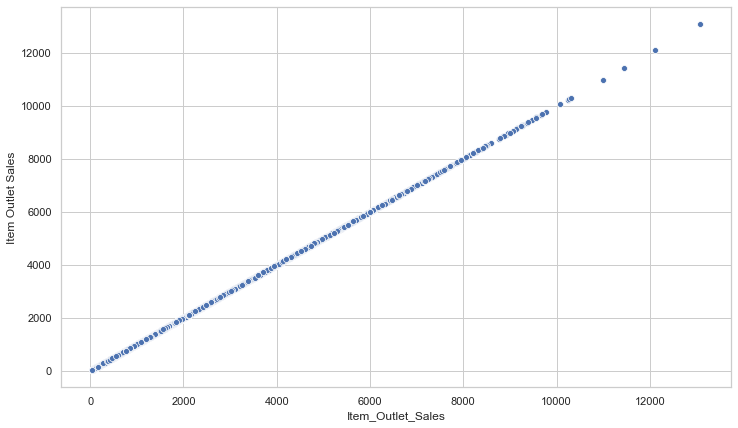

In [35]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(x='Item_Outlet_Sales', y='Item_Outlet_Sales', data=df_full)
ax.set_xlabel('Item_Outlet_Sales')
ax.set_ylabel('Item Outlet Sales')
plt.show()

### 1.2 General correlation between Item_Outlet_Sales and other variables 

Now we need to explore the correlation between Item_Outlet_Sales and all other variables in the dataset. According to the output, Item_MRP and Outlet_Identifier have the highest correlation with the Item_Outlet_Sales column by far. Next, all variables will be explored in accordance with their correlation ranking from highest to lowest. 

In [36]:
a = df_train.corr()["Item_Outlet_Sales"]
a = a.apply(abs)
a = a.drop(['Item_Outlet_Sales'])
a.sort_values(ascending=False)

Item_MRP                     0.567574
Outlet_Identifier            0.383738
Item_Visibility              0.128625
Outlet_Location_Type         0.089367
Outlet_Size                  0.086182
Outlet_Establishment_Year    0.049135
Item_Type                    0.035899
Outlet_Type                  0.020871
Item_Fat_Content             0.018719
Item_Weight                  0.009693
Name: Item_Outlet_Sales, dtype: float64

### 1.3 Item_MRP (Maximum Retail Price (list price) of the product) 

Item_MRP column has outstandingly definite distirbution of values - five groups with different level of sales, and the transition from one level to another is linear, which makes it a near-perfect predictor for a problem that is also related to linear regression in its essence.

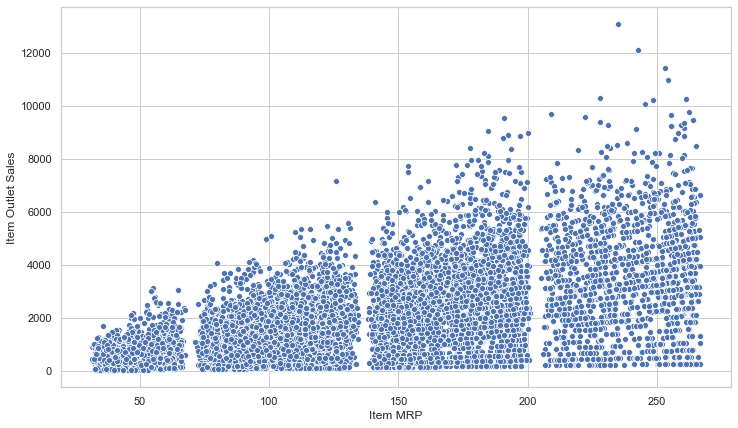

In [37]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=df_full)
ax.set_xlabel('Item MRP')
ax.set_ylabel('Item Outlet Sales')
plt.show()

### 1.4 Outlet_Identifier (Unique store ID)

Here we have a rather complex yet distinct distribution of values, as there is one store that stands out in terms of high sales, a group of outlets with average values, and two stores with sales well below average. This makes Outlet_Identifier the second best predictor. 

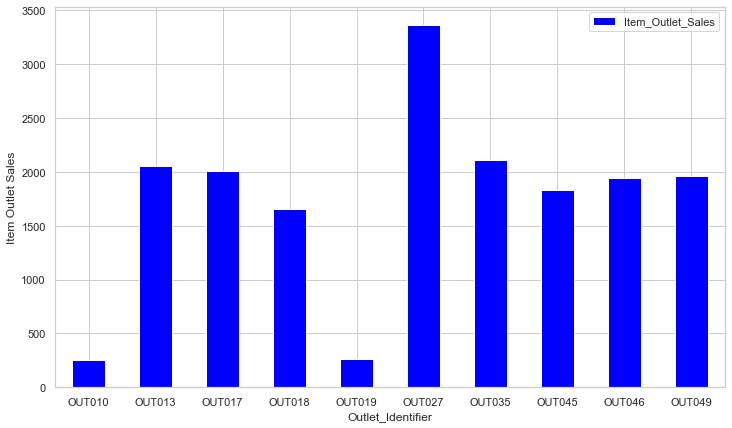

In [38]:
a = df_full[['Outlet_Identifier', 'Item_Outlet_Sales']].groupby( 'Outlet_Identifier' ).median()
a.plot( kind='bar', color='blue', figsize=(12,7) )

plt.xlabel( 'Outlet_Identifier' )
plt.ylabel( 'Item Outlet Sales' )
plt.xticks( rotation=0 );

### 1.5 Item_Visibility (The % of total display area of all products in a store allocated to the particular product)

Item_Visibility is the third best predictor according to the section 1.2 for a reason - it is obvious that items with the value below 0.20 have much higher sales than those with the value above 0.20.

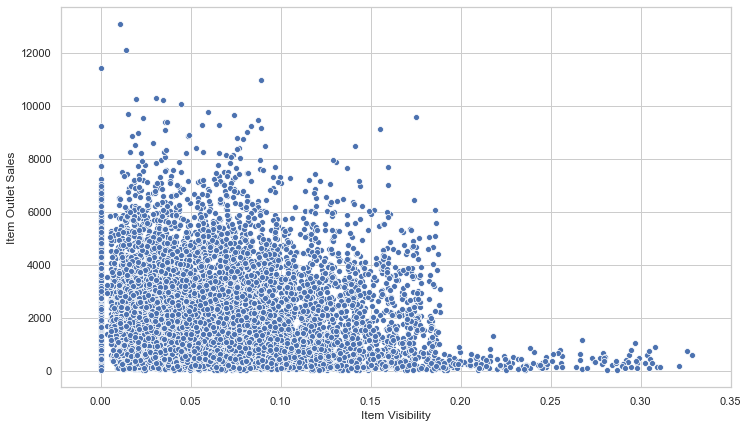

In [39]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(x='Item_Visibility', y='Item_Outlet_Sales', data=df_full)
ax.set_xlabel('Item Visibility')
ax.set_ylabel('Item Outlet Sales')
plt.show()

### 1.6 Outlet_Size (The size of the store in terms of ground area covered)

Once again, there is clear and relatively substantial difference among the three groups of outlet sizes, and this is likely to make a positive difference during prediction. 

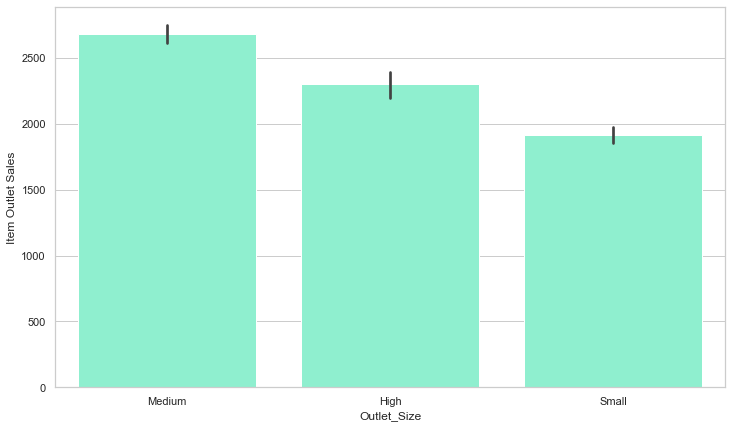

In [40]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Outlet_Size', y='Item_Outlet_Sales', data=df_full, color="aquamarine")
ax.set_xlabel('Outlet_Size')
ax.set_ylabel('Item Outlet Sales')
plt.show()

### 1.7 Outlet_Location_Type (The type of city in which the store is located)

Here we see clear and relatively significant difference between three types of locations, hence the Outlet_Location_Type column is likely to help in accurate prediciton of sales. 

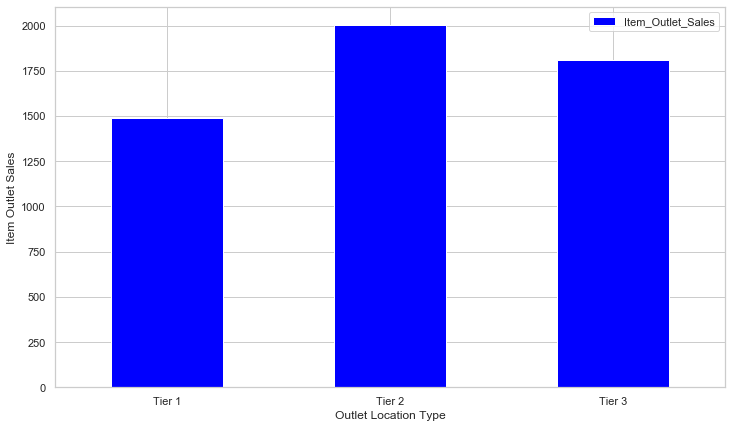

In [41]:
a = df_full[['Outlet_Location_Type', 'Item_Outlet_Sales']].groupby( 'Outlet_Location_Type' ).median()
a.plot( kind='bar', color='blue', figsize=(12, 7) )
plt.xlabel( 'Outlet Location Type')
plt.ylabel( 'Item Outlet Sales' )
plt.xticks( rotation=0 );

### 1.8 Outlet_Establishment_Year (The year in which store was established)

Sales for the outlet established in 1998 are much lower than for the rest of them. However, this is not enough to compensate for confusion that this variable might cause if included into a predictive model. 

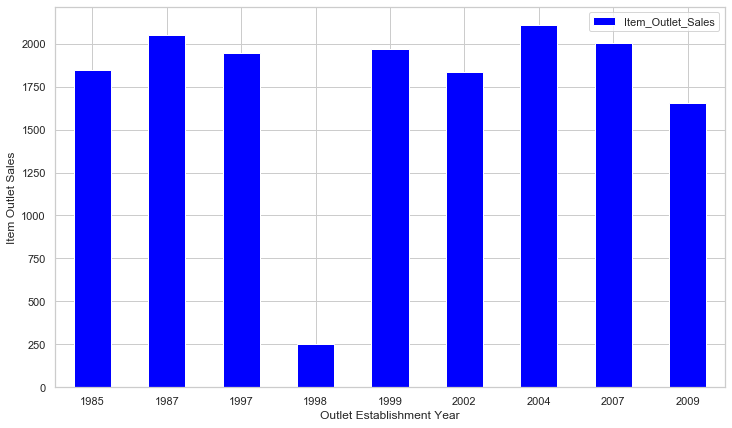

In [42]:
a = df_full[['Outlet_Establishment_Year', 'Item_Outlet_Sales']].groupby( 'Outlet_Establishment_Year' ).median()
a.plot( kind='bar', color='blue', figsize=(12, 7) )
plt.xlabel( 'Outlet Establishment Year')
plt.ylabel( 'Item Outlet Sales' )
plt.xticks( rotation=0 );

### 1.9 Item_Type (The category to which the product belongs)

There is no strong correlation between Item_Type and Item_Outlet_Sales columns, so the Item_Type variable is not likely to be an important predictor. 

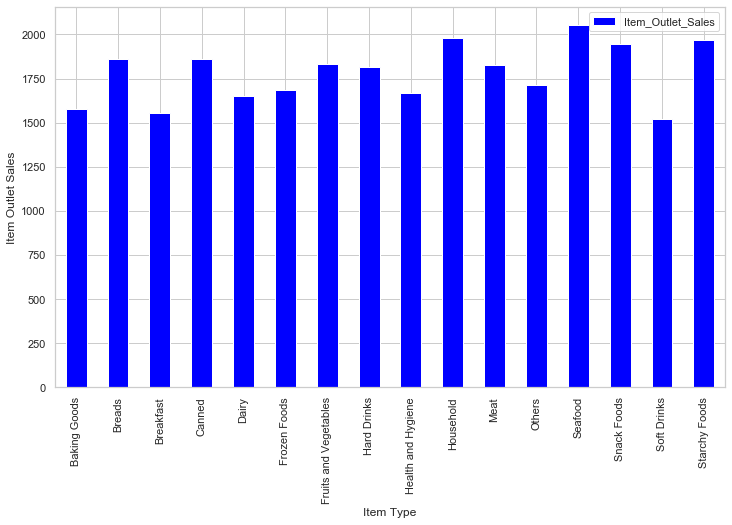

In [43]:
a = df_full[['Item_Type', 'Item_Outlet_Sales']].groupby( 'Item_Type' ).median()
a.plot( kind='bar', color='blue', figsize=(12, 7) )
plt.xlabel( 'Item Type')
plt.ylabel( 'Item Outlet Sales' )
plt.xticks( rotation=90 );

### 1.10 Outlet_Type (Whether the outlet is just a grocery store or some sort of supermarket)

There is a significant difference among Supermarket Type 3, Type1/Typ2, and Grocery Store. However, little difference between Supermarket Types 1 and 2 will likely create confusion, same as merging these two types into one. This makes Outlet_Type not a good predictor.

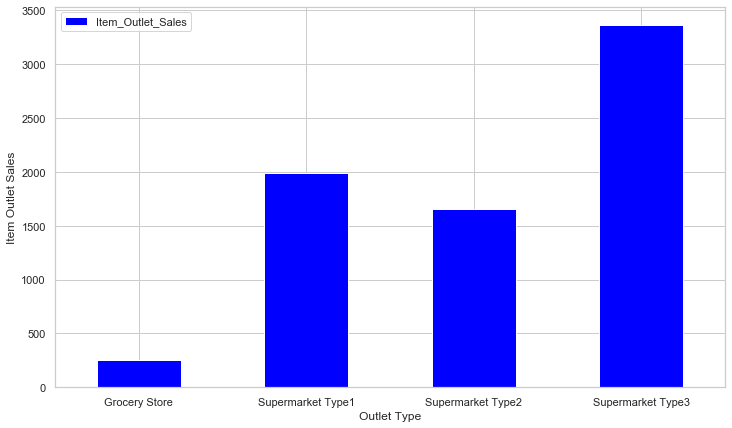

In [44]:
a = df_full[['Outlet_Type', 'Item_Outlet_Sales']].groupby( 'Outlet_Type' ).median()
a.plot( kind='bar', color='blue', figsize=(12, 7) )
plt.xlabel( 'Outlet Type')
plt.ylabel( 'Item Outlet Sales' )
plt.xticks( rotation=0 );

### 1.11 Item_Fat_Content (Whether the product is low fat or not)

There is next to no difference between two values in the Item_Fat_Content column, hence there is no surprise that this variable is the 2nd weakest predictor within the dataset. 

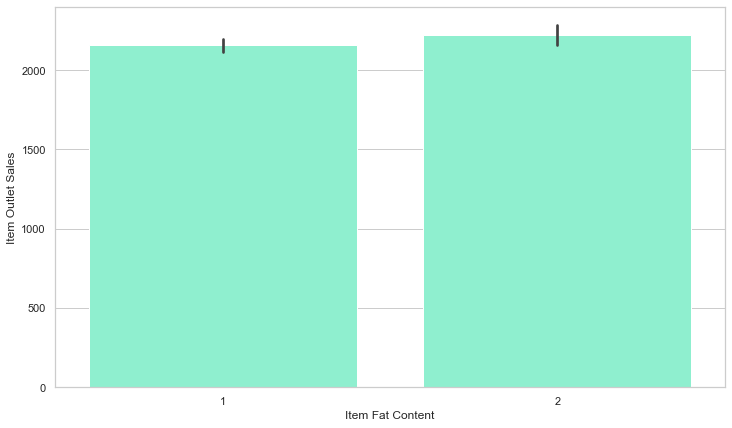

In [45]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='Item_Fat_Content', y='Item_Outlet_Sales', data=df_train, color="aquamarine")
ax.set_xlabel('Item Fat Content')
ax.set_ylabel('Item Outlet Sales')
plt.show()

### 1.12 Item_Weight (Weight of product)

The distribution of values in the Item_Weight column is very diverse, and fully confirms that this variable is the weakest predictor. 

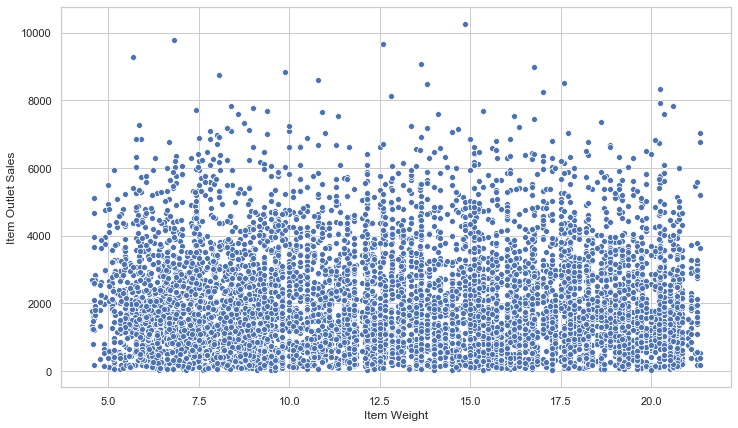

In [46]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(x='Item_Weight', y='Item_Outlet_Sales', data=df_full)
ax.set_xlabel('Item Weight')
ax.set_ylabel('Item Outlet Sales')
plt.show()

## 2. Predictive modeling

### 2.1 Initial model and submission (default train dataset, all variables)

Since in this case the Random Forest approach gives substantially higher accuracy than Linear Regression by default, Random Forest will be used in the subsequent iterations. 

In [47]:
columns = df_train.columns.tolist()

columns = [c for c in columns if c not in ["Item_Outlet_Sales"]]

target = "Item_Outlet_Sales"

In [48]:
train = df_train.sample(frac=0.8, random_state=1)

test = df_train.loc[~df_train.index.isin(train.index)]

print(train.shape)
print(test.shape)

(6818, 11)
(1705, 11)


In [49]:
model = LinearRegression()

model.fit(train[columns], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
predictions = model.predict(test[columns])

mean_squared_error(predictions, test[target])

1537208.7349865183

In [51]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns], train[target])

predictions = model.predict(test[columns])

mean_squared_error(predictions, test[target])

1226881.5883803396

In [52]:
columns = df_test.columns.tolist()
predictions = model.predict(df_test)

In [53]:
predictions

array([1581.13601985, 1386.11815376,  606.63858373, ..., 1831.48556974,
       3631.61544884, 1405.02269941])

In [54]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\1.csv', index=False)

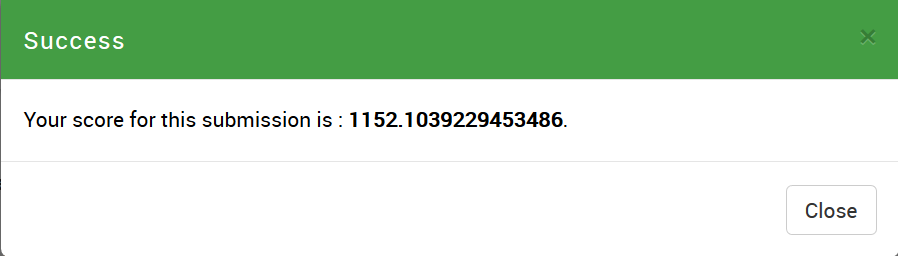

In [55]:
Image(filename = '1.png')

### 2.2 First stage of feature selection

Even removing just the 2 weakest predictors - Item_Weight and Item_Fat_Content - substantially improves the submission's accuracy. 

In [56]:
columns_train = df_train.columns.tolist()

columns_train = [c for c in columns_train if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type']]

target = "Item_Outlet_Sales"

In [57]:
train = df_train.sample(frac=0.8, random_state=1)

test = df_train.loc[~df_train.index.isin(train.index)]

print(train.shape)
print(test.shape)

(6818, 11)
(1705, 11)


In [58]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train], train[target])

predictions = model.predict(test[columns_train])

mean_squared_error(predictions, test[target])

1231300.375041387

In [59]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type']]

predictions = model.predict(df_test[columns_test])

predictions

array([1670.89280591, 1357.84321053,  603.18422812, ..., 1753.80898953,
       3572.45650078, 1399.61655346])

In [60]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\2.csv', index=False)

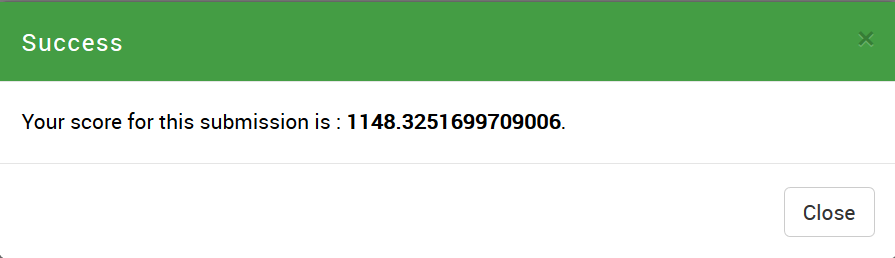

In [61]:
Image(filename = '2.png')

### 2.3 Appending the predictions of the stage 2.2 to the train dataset

Adding previous submission's results to the initial train dataset can very well be a way of improving the accuracy of the submission. But it hasn't helped yet, because the initial model needs adjustment of its parameters. 

In [62]:
df_train1mix_prep = df_test
df_train1mix_prep['Item_Outlet_Sales']= df3['Item_Outlet_Sales']
df_train1mix = pd.DataFrame(np.concatenate([df_train.values, df_train1mix_prep.values]), columns=df_train.columns)
df_train1mix.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\train1mix.csv', index=False)

In [63]:
columns_train1mix = df_train1mix.columns.tolist()

columns_train1mix = [c for c in columns_train1mix if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type']]

target = "Item_Outlet_Sales"

In [64]:
train = df_train1mix.sample(frac=0.8, random_state=1)

test = df_train1mix.loc[~df_train1mix.index.isin(train.index)]

print(train.shape)
print(test.shape)

(11363, 11)
(2841, 11)


In [65]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train1mix], train[target])

predictions = model.predict(test[columns_train1mix])

mean_squared_error(predictions, test[target])

712335.4173012906

In [66]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type']]

predictions = model.predict(df_test[columns_test])

predictions

array([1655.88010471, 1344.7474933 ,  609.08639387, ..., 1742.1228062 ,
       3601.23258324, 1434.87206972])

In [67]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\3.csv', index=False)

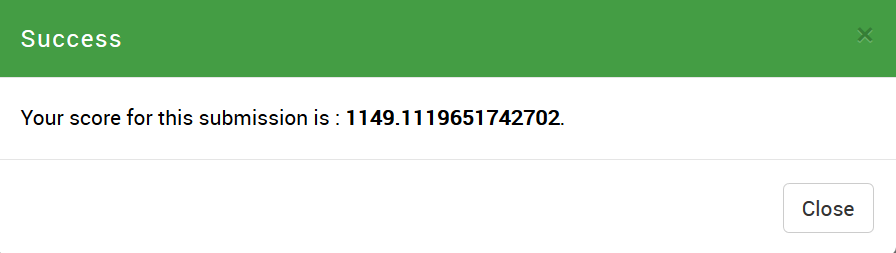

In [68]:
Image(filename = '3.png')

### 2.4 Adjusting the parameters of the train sample selection, and initial Random Forest model

Changing the sampling fraction to 0.921 and random state to 30 during the creation of the training set, as well as changing the n_estimators value to 299 and min_samples_leaf to 70 during the creation of a new model, has once again dramatically increased the submission's performance.

In [69]:
train = df_train1mix.sample(frac=0.921, random_state=30)

test = df_train1mix.loc[~df_train1mix.index.isin(train.index)]

print(train.shape)
print(test.shape)

(13082, 11)
(1122, 11)


In [70]:
model = RandomForestRegressor(n_estimators=299, min_samples_leaf=70, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train1mix], train[target])

predictions = model.predict(test[columns_train1mix])

mean_squared_error(predictions, test[target])

691350.1408036574

In [71]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type']]

predictions = model.predict(df_test[columns_test])

predictions

array([1646.5911447 , 1335.06099802,  594.64550539, ..., 1826.23593228,
       3636.51008126, 1357.57287563])

In [72]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\4.csv', index=False)

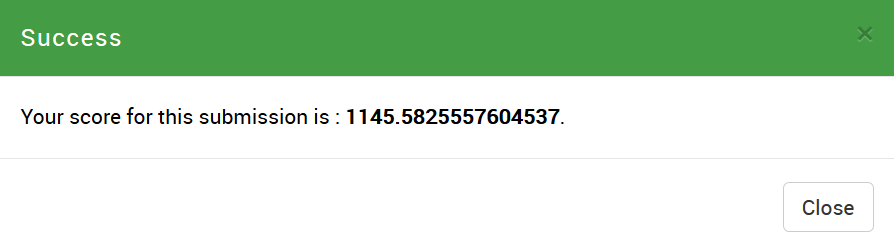

In [73]:
Image(filename = '4.png')

### 2.5 Second stage of feature selection

At this stage, only the top-5 features indentified in the 1.2 section were used, which has further improved the submission's accuracy.

In [74]:
columns_train1mix = df_train1mix.columns.tolist()

columns_train1mix = [c for c in columns_train1mix if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size']]

target = "Item_Outlet_Sales"

In [75]:
train = df_train1mix.sample(frac=0.921, random_state=30)

test = df_train1mix.loc[~df_train1mix.index.isin(train.index)]

print(train.shape)
print(test.shape)

(13082, 11)
(1122, 11)


In [76]:
model = RandomForestRegressor(n_estimators=299, min_samples_leaf=70, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train1mix], train[target])

predictions = model.predict(test[columns_train1mix])

mean_squared_error(predictions, test[target])

693749.4563249848

In [77]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size']]

predictions = model.predict(df_test[columns_test])

predictions

array([1666.40621104, 1325.68025167,  609.28207189, ..., 1815.19894965,
       3618.52357747, 1343.08613728])

In [78]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\5.csv', index=False)

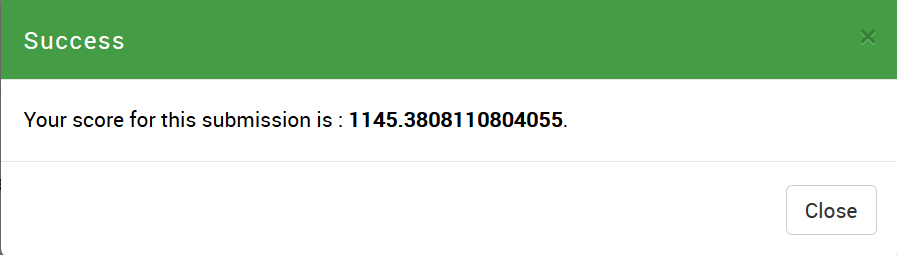

In [79]:
Image(filename = '5.png')

### 2.6 Feature engineering

Sometimes creation of new features based on those that already exist in the dataset can get more accurate predictions. In this case, two new variables/features were created: 

1. Item_Type was transformed into 'goodtype', meaning that all products were grouped into 3 broad categories - food, drinks, and nonedibles
2. 'vis_broad' feature was created based on the existing Item_Visibility variable, and it broke all values into two - those less that 0.2 and more than 0.2

However, feature engineering hasn't improved the model's accuracy in this case. 

#### 2.6.1 Using the parameters from stage 2.1

In [80]:
df_train = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\train1.csv')

In [81]:
df_test = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\test1.csv')

In [82]:
df_train.loc[df_train.Item_Type == 1, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 2, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 4, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 5, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 6, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 7, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 8, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 10, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 11, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 13, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 14, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 15, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 16, 'goodtype'] = 1
df_train.loc[df_train.Item_Type == 3, 'goodtype'] = 2
df_train.loc[df_train.Item_Type == 8, 'goodtype'] = 2
df_train.loc[df_train.Item_Type == 9, 'goodtype'] = 3
df_train.loc[df_train.Item_Type == 12, 'goodtype'] = 3

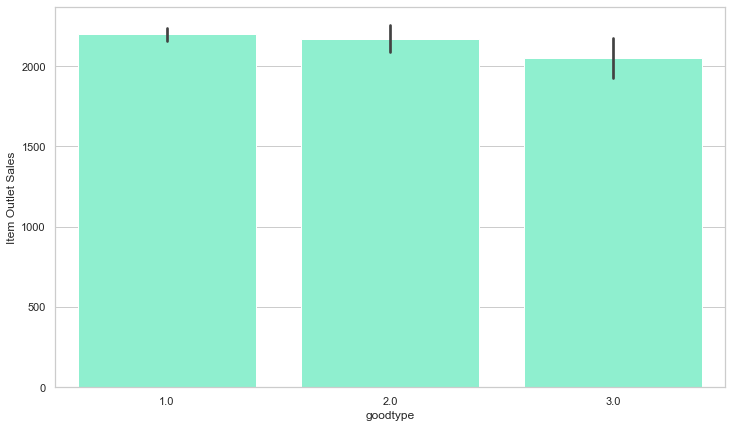

In [83]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='goodtype', y='Item_Outlet_Sales', data=df_train, color="aquamarine")
ax.set_xlabel('goodtype')
ax.set_ylabel('Item Outlet Sales')
plt.show()

In [84]:
df_train['vis_broad']=np.where(df_train['Item_Visibility']<0.20, 0, 1)

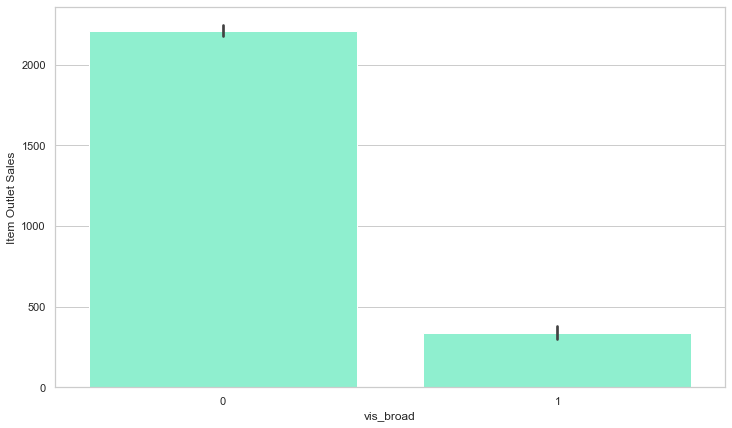

In [85]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x='vis_broad', y='Item_Outlet_Sales', data=df_train, color="aquamarine")
ax.set_xlabel('vis_broad')
ax.set_ylabel('Item Outlet Sales')
plt.show()

In [86]:
df_train.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\train_feat.csv', index=False)

In [87]:
df_test.loc[df_test.Item_Type == 1, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 2, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 4, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 5, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 6, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 7, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 8, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 10, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 11, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 13, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 14, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 15, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 16, 'goodtype'] = 1
df_test.loc[df_test.Item_Type == 3, 'goodtype'] = 2
df_test.loc[df_test.Item_Type == 8, 'goodtype'] = 2
df_test.loc[df_test.Item_Type == 9, 'goodtype'] = 3
df_test.loc[df_test.Item_Type == 12, 'goodtype'] = 3

In [88]:
df_test['vis_broad']=np.where(df_test['Item_Visibility']<0.20, 0, 1)

In [89]:
df_test.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\test_feat.csv', index=False)

In [90]:
columns = df_train.columns.tolist()

columns = [c for c in columns if c not in ["Item_Outlet_Sales"]]

target = "Item_Outlet_Sales"

In [91]:
train = df_train.sample(frac=0.8, random_state=1)

test = df_train.loc[~df_train.index.isin(train.index)]

print(train.shape)
print(test.shape)

(6818, 13)
(1705, 13)


In [92]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns], train[target])

predictions = model.predict(test[columns])

mean_squared_error(predictions, test[target])

1228859.0287179486

In [93]:
columns = df_test.columns.tolist()
predictions = model.predict(df_test)

In [94]:
predictions

array([1570.97547964, 1356.42992717,  597.36820678, ..., 1840.94139361,
       3688.1918476 , 1415.4030395 ])

In [95]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\6.csv', index=False)

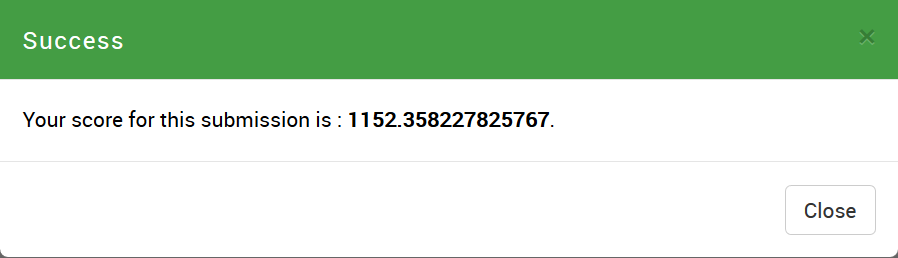

In [96]:
Image(filename = '6(to 1).png')

#### 2.6.2 Using the parameters from stage 2.2

In [97]:
columns_train = df_train.columns.tolist()

columns_train = [c for c in columns_train if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type', 'goodtype', 'vis_broad']]

target = "Item_Outlet_Sales"

In [98]:
train = df_train.sample(frac=0.8, random_state=1)

test = df_train.loc[~df_train.index.isin(train.index)]

print(train.shape)
print(test.shape)

(6818, 13)
(1705, 13)


In [99]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train], train[target])

predictions = model.predict(test[columns_train])

mean_squared_error(predictions, test[target])

1232386.3001850036

In [100]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type', 'goodtype', 'vis_broad']]

predictions = model.predict(df_test[columns_test])

predictions

array([1669.80718088, 1364.10540929,  603.08717032, ..., 1756.37788297,
       3587.37505804, 1386.481623  ])

In [101]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\7.csv', index=False)

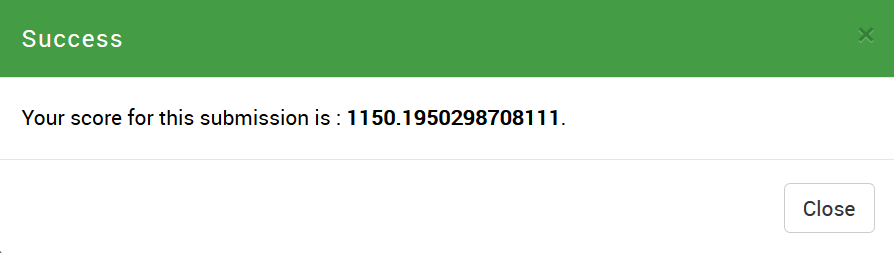

In [102]:
Image(filename = '7(to 2).png')

#### 2.6.3 Using the parameters from stage 2.5

In [103]:
columns_train = df_train.columns.tolist()

columns_train = [c for c in columns_train if c in ['Item_MRP', 'Outlet_Identifier', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type', 'vis_broad']]

target = "Item_Outlet_Sales"

In [104]:
train = df_train.sample(frac=0.8, random_state=1)

test = df_train.loc[~df_train.index.isin(train.index)]

print(train.shape)
print(test.shape)

(6818, 13)
(1705, 13)


In [105]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train], train[target])

predictions = model.predict(test[columns_train])

mean_squared_error(predictions, test[target])

1232982.1095180388

In [106]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 
                                                   'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Establishment_Year',
                                                   'Outlet_Type', 'vis_broad']]

predictions = model.predict(df_test[columns_test])

predictions

array([1626.43261781, 1367.22626832,  604.50662456, ..., 1789.57458013,
       3671.70924188, 1363.97086   ])

In [107]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\8.csv', index=False)

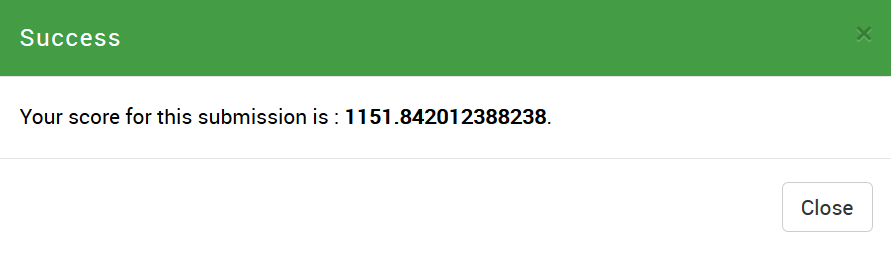

In [108]:
Image(filename = '8(to 2).png')

### 2.7 Removing outliers from Item_Outlet_Sales column

Removing outliers from the training dataset is another possible way of improving the accuracy of predictions. But it didn't work in this case, as accuracy had actually decreased. 

#### 2.7.1 Using the parameters from section 2.5

In [109]:
df_train1mix = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\train1mix.csv')

In [110]:
df_test = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\test1.csv')

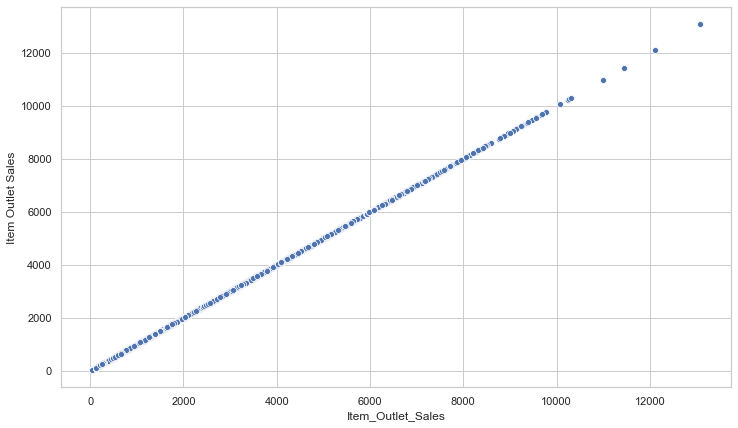

In [111]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(x='Item_Outlet_Sales', y='Item_Outlet_Sales', data=df_train1mix)
ax.set_xlabel('Item_Outlet_Sales')
ax.set_ylabel('Item Outlet Sales')
plt.show()

In [112]:
df_train1mix = df_train1mix[df_train1mix.Item_Outlet_Sales < 10000]

In [113]:
columns_train1mix = df_train1mix.columns.tolist()

columns_train1mix = [c for c in columns_train1mix if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size']]

target = "Item_Outlet_Sales"

In [114]:
train = df_train1mix.sample(frac=0.921, random_state=30)

test = df_train1mix.loc[~df_train1mix.index.isin(train.index)]

print(train.shape)
print(test.shape)

(13075, 11)
(1121, 11)


In [115]:
model = RandomForestRegressor(n_estimators=299, min_samples_leaf=70, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train1mix], train[target])

predictions = model.predict(test[columns_train1mix])

mean_squared_error(predictions, test[target])

708566.0326828941

In [116]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size']]

predictions = model.predict(df_test[columns_test])

predictions

array([1678.56564947, 1334.49856219,  613.57048592, ..., 1787.28106203,
       3684.14274042, 1350.76230799])

In [117]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\9.csv', index=False)

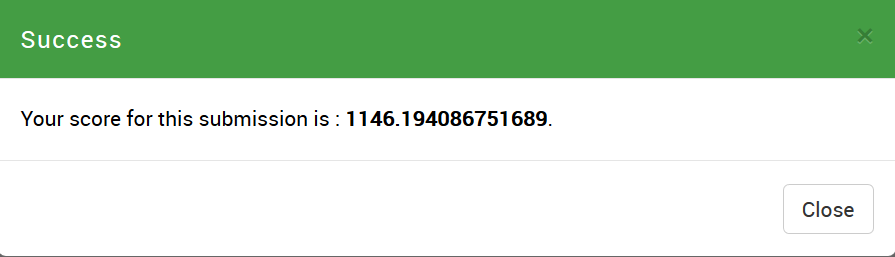

In [118]:
Image(filename = '9(to 5).png')

#### 2.7.2 Using the parameters from section 2.1 

In [119]:
df_train = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\train1.csv')

In [120]:
df_test = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\test1.csv')

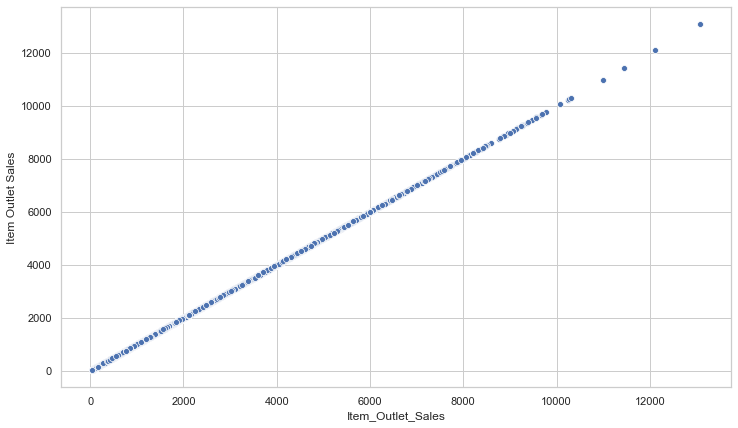

In [121]:
plt.figure(figsize=(12,7))
ax = sns.scatterplot(x='Item_Outlet_Sales', y='Item_Outlet_Sales', data=df_train)
ax.set_xlabel('Item_Outlet_Sales')
ax.set_ylabel('Item Outlet Sales')
plt.show()

In [122]:
df_train = df_train[df_train.Item_Outlet_Sales < 10000]

In [123]:
columns = df_train.columns.tolist()

columns = [c for c in columns if c not in ["Item_Outlet_Sales"]]

target = "Item_Outlet_Sales"

In [124]:
train = df_train.sample(frac=0.8, random_state=1)

test = df_train.loc[~df_train.index.isin(train.index)]

print(train.shape)
print(test.shape)

(6812, 11)
(1703, 11)


In [125]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=50, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns], train[target])

predictions = model.predict(test[columns])

mean_squared_error(predictions, test[target])

1190239.001191966

In [126]:
columns = df_test.columns.tolist()
predictions = model.predict(df_test)

In [127]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\10.csv', index=False)

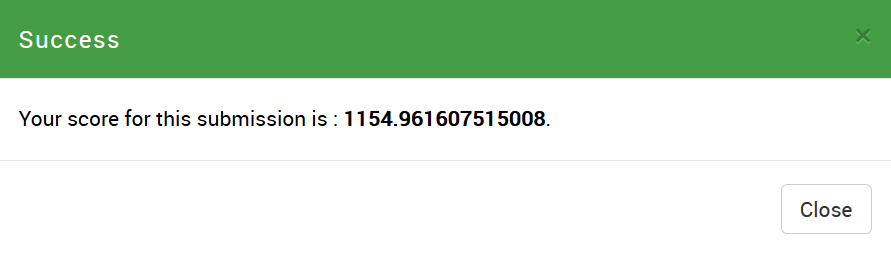

In [128]:
Image(filename = '10(to 1).png')

## 3. Final model and conclusion

### 3.1 Final model's submission result and leaderboard performance

In [129]:
df_train1mix = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\train1mix.csv')

In [130]:
df_test = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\test1.csv')

In [131]:
columns_train1mix = df_train1mix.columns.tolist()

columns_train1mix = [c for c in columns_train1mix if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size']]

target = "Item_Outlet_Sales"

In [132]:
train = df_train1mix.sample(frac=0.921, random_state=30)

test = df_train1mix.loc[~df_train1mix.index.isin(train.index)]

print(train.shape)
print(test.shape)

(13082, 11)
(1122, 11)


In [133]:
model = RandomForestRegressor(n_estimators=299, min_samples_leaf=70, random_state=30, n_jobs=1, max_features=0.9)

model.fit(train[columns_train1mix], train[target])

predictions = model.predict(test[columns_train1mix])

mean_squared_error(predictions, test[target])

693797.5897638642

In [134]:
columns_test = df_test.columns.tolist()

columns_test = [c for c in columns_test if c in ['Item_MRP', 'Outlet_Identifier', 'Item_Visibility', 
                                                   'Outlet_Location_Type', 'Outlet_Size']]

predictions = model.predict(df_test[columns_test])

predictions

array([1666.40621104, 1325.68025167,  608.88595951, ..., 1815.19894965,
       3618.54414568, 1343.08613728])

In [135]:
df1 = pd.DataFrame(predictions, columns=["Item_Outlet_Sales"])

df2 = pd.read_csv('D:\\SciKitDatasets\\misc\\BigMart3\\pred.csv')

df3 = pd.concat([df2, df1], axis=1)

df3.to_csv('D:\\SciKitDatasets\\misc\\BigMart3\\clean\\5_1.csv', index=False)

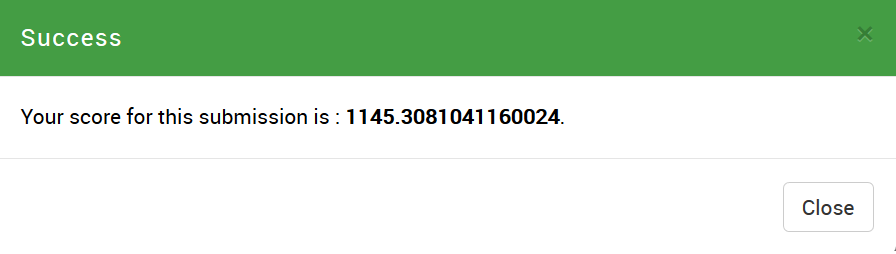

In [136]:
Image(filename = '5_1.png')

The result, obtained with the final model of this notebook, can get one close to the top 100 of the leaderboard, or well into the top 5% of this hackathon, which means that the model is quite good.

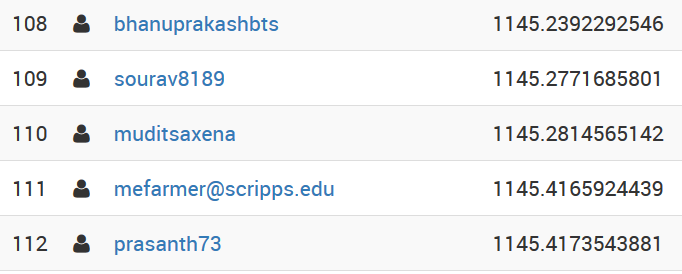

In [137]:
Image(filename = 'lboard.png')

### 3.2 Final model's decision tree visualization

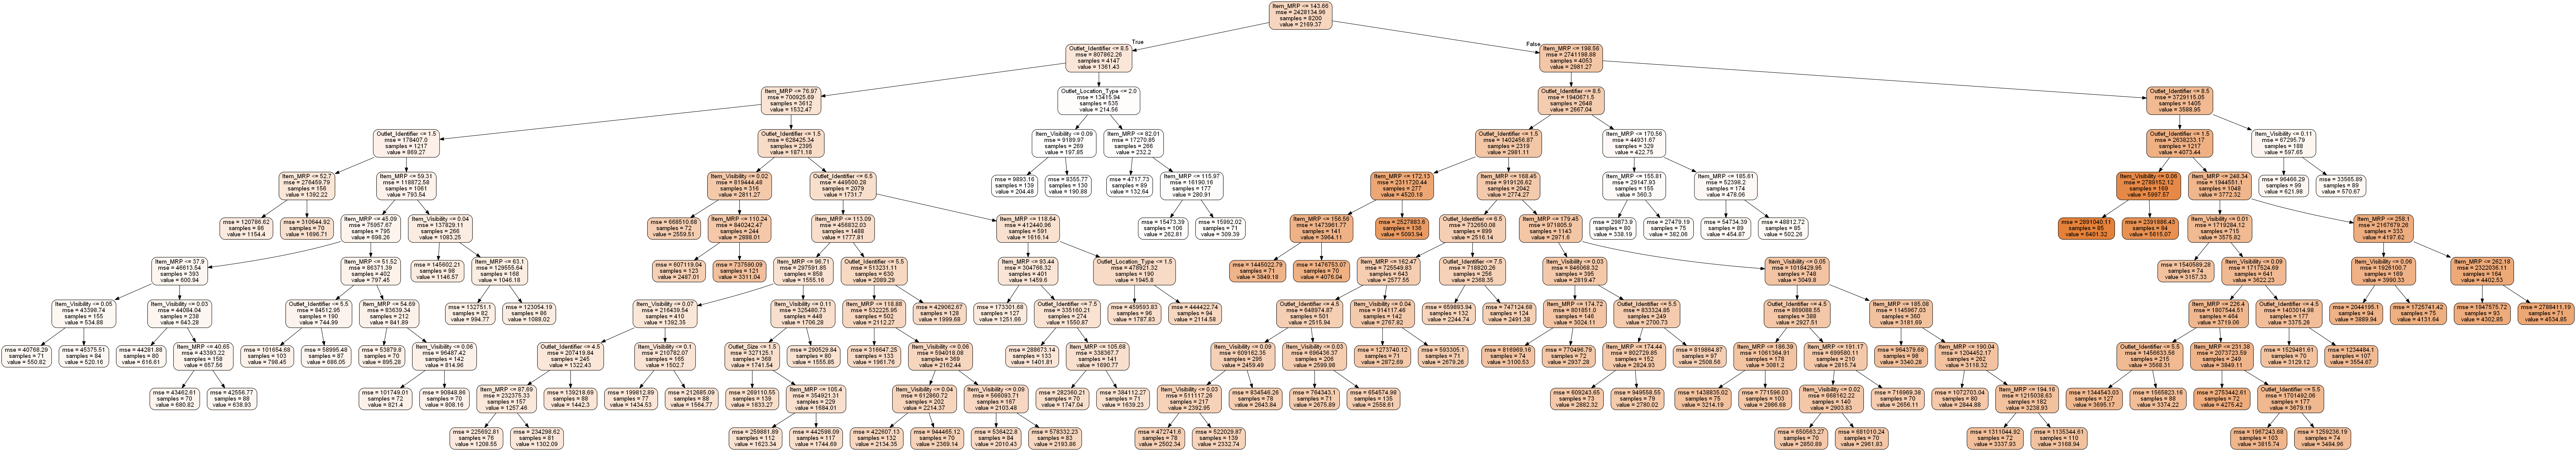

In [138]:
estimator_limited = model.estimators_[5]

export_graphviz(estimator_limited, out_file='tree_limited.dot', feature_names = columns_train1mix, 
                rounded = True, proportion = False, precision = 2, filled = True)

call(['dot', '-Tpng', 'tree_limited.dot', '-o', 'tree_limited.png'])

Image(filename = 'tree_limited.png')

### 3.3 Final model's interpretation

#### 3.3.1 Correlations between Item_Outlet_Sales and other variables in the df_train1mix dataset, used for training the final model

In [139]:
a = df_train1mix.corr()["Item_Outlet_Sales"]
a = a.apply(abs)
a = a.drop(['Item_Outlet_Sales'])
a.sort_values(ascending=False)

Item_MRP                     0.615926
Outlet_Identifier            0.415929
Item_Visibility              0.136975
Outlet_Size                  0.100992
Outlet_Location_Type         0.100613
Outlet_Establishment_Year    0.053035
Item_Type                    0.029545
Outlet_Type                  0.029328
Item_Weight                  0.017449
Item_Fat_Content             0.005245
Name: Item_Outlet_Sales, dtype: float64

#### 3.3.2 Feature importances of the final random forest model

In [140]:
final_model_coefs = model.feature_importances_.flatten()
final_model_coefs = final_model_coefs.tolist()
final_model_coefs

df_final_model_coefs = pd.DataFrame({'Feature':columns_train1mix, 'Importance':final_model_coefs}, columns=['Feature','Importance'])
df_final_model_coefs = df_final_model_coefs.sort_values('Importance', ascending=False)
df_final_model_coefs = df_final_model_coefs.reset_index(drop=True)
df_final_model_coefs

,Feature,Importance
0,Item_MRP,0.554653
1,Outlet_Identifier,0.435094
2,Item_Visibility,0.006736
3,Outlet_Location_Type,0.002730
4,Outlet_Size,0.000787


### 3.4 Main predictors of sales

Visualization of feature importances from the final Random Forest model shows that Item_MRP and Outlet_Identifier are by far the most important predictors of sales at least in case with this dataset, and probably in many other real-world cases of retail industry. This result is also largely in line with the initial correlation figures, obtained in section 1.2 of this notebook.

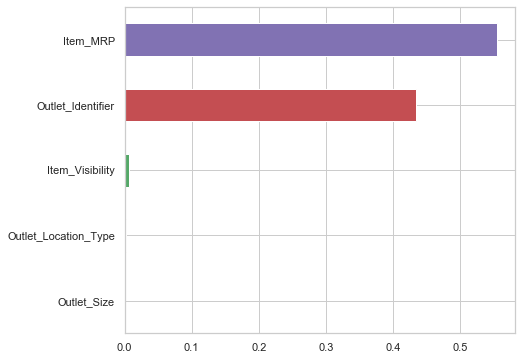

In [141]:
%matplotlib inline

feature_importances = pd.Series(model.feature_importances_, index=columns_train1mix)
feature_importances.sort_values(axis=0, ascending=True, kind='quicksort', na_position='last', inplace=True)
feature_importances.plot(kind="barh", figsize=(7,6));

### 3.5 My final leaderboard result

Using the mix of approaches from sections 2.1-2.5 of this notebook, I've managed to reach the 35th place of the leaderboard, which puts my result well into the top 1% in this hackathon.

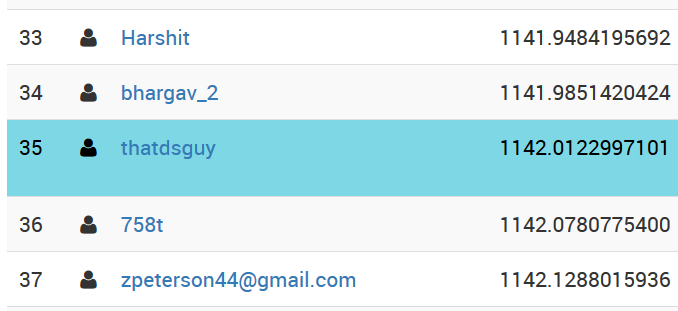

In [142]:
Image(filename = 'final_result.png')